Start with basic package imports

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from numba import jit

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt

# Download and Prepare Data

Download ERAi and re-forecast data 

In [2]:
download_data = True # change if desired
if download_data:
    !rm -Rf hgt_ecmwf_ctrl.nc hgt_ecmwf_prtb.nc hgt_ecmwf_rean.nc
    !curl -k -b '__dlauth_id=017a28e8531cac13efd89be8a7612c4c0754a83606f8f90270d14d84f62c28d7ff7fe8fbfb04c0495ddf938392d0bf3d9617e8b7' 'https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.control/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(last)/VALUE/S/removeGRID/hdate/(1998)/(2017)/RANGE/X/(-170)/(-30)/RANGE/Y/(20)/(80)/RANGE/data.nc' >hgt_ecmwf_ctrl.nc
    !curl -k -b '__dlauth_id=017a28e8531cac13efd89be8a7612c4c0754a83606f8f90270d14d84f62c28d7ff7fe8fbfb04c0495ddf938392d0bf3d9617e8b7' 'https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(last)/VALUE/hdate/(1998)/(2017)/RANGE/X/(-170)/(-30)/RANGE/Y/(20)/(80)/RANGE/S/removeGRID/data.nc' >hgt_ecmwf_prtb.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.3M  100 14.3M    0     0   562k      0  0:00:26  0:00:26 --:--:-- 3886k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  143M  100  143M    0     0   615k      0  0:03:57  0:03:57 --:--:-- 8372k   0    0     0      0      0 --:--:--  0:00:38 --:--:--     0


In [4]:
model = xr.open_dataset('./hgt_ecmwf_prtb.nc',decode_times=False)
model = model.stack(time=['hdate', 'L'], grid=['X', 'Y'])   #trick to deal with the time coordinates
model = model - model.mean(dim='time') #anomalies
model['M']=model['M'].astype(int)
model

<xarray.Dataset>
Dimensions:  (M: 10, grid: 3990, time: 940)
Coordinates:
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10
  * time     (time) MultiIndex
  - hdate    (time) float64 462.0 462.0 462.0 462.0 462.0 462.0 462.0 462.0 ...
  - L        (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 ...
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 27.0 28.5 30.0 31.5 ...
Data variables:
    gh       (M, time, grid) float32 12.814941 3.0932617 -6.477051 ...

In [5]:
reanalysis = xr.open_dataset('./hgt_ecmwf_ctrl.nc',decode_times=False)
reanalysis = reanalysis.stack(time=['hdate', 'L'], grid=['X', 'Y']) #trick to deal with the time coordinates
reanalysis = reanalysis - reanalysis.mean(dim='time')  #anomalies
reanalysis

<xarray.Dataset>
Dimensions:  (grid: 3990, time: 940)
Coordinates:
  * time     (time) MultiIndex
  - hdate    (time) float64 462.0 462.0 462.0 462.0 462.0 462.0 462.0 462.0 ...
  - L        (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 ...
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 27.0 28.5 30.0 31.5 ...
Data variables:
    gh       (time, grid) float32 12.364746 2.7875977 -4.753418 -11.555664 ...

# Dimension Reduction

We need tho choose a percentage of variance explained that we will require:

In [6]:
var_to_explain = 0.9 # write as proportion not percentage

In [7]:
pca = PCA().fit(reanalysis['gh'].values)
var_explained = pca.explained_variance_ratio_
cum_var = var_explained.cumsum()
n_eof = np.where(cum_var > var_to_explain)[0].min()
print(n_eof)

21


Plot the variance explained

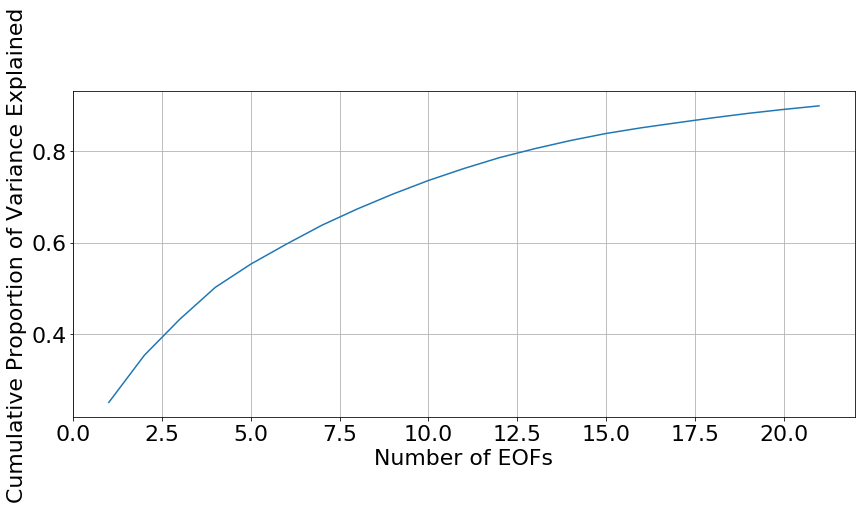

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(np.arange(1, n_eof + 1), cum_var[0:n_eof])
plt.xlabel('Number of EOFs')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.grid()
plt.show()

Now we project the data onto the leading EOFs to get the principal component time series

In [9]:
pca = PCA(n_components=n_eof).fit(reanalysis['gh'].values)
pc_ts = pca.transform(reanalysis['gh'].values)

# Reanalysis Weather Typing

Now we perform the clustering.

We will manually specify the number of clusters we want to create and the number of simulations we want to run.

In [10]:
ncluster = 4 # ASSUME 4 Clusters
n_sim = 50 # typically 50-100

Each simulation gives us centroids indexed by (weather type, EOF) and weather types indexed by (time).
Since we are doing many simulations, we will add that as the first index.
We'll create a function to create many simulations of the kmeans clustering algorithm so that we can compile it using the `jit` decorator, which speeds things up nicely

In [11]:
@jit
def _vector_ci(P, Q):
    """Implement the Michaelangeli (1995) Classifiability Index

    The variable naming here is not pythonic but follows the notation in the 1995 paper
    which makes it easier to follow what is going on. You shouldn't need to call
    this function directly but it is called in cluster_xr_eof.

    Args:
        P: a cluster centroid
        Q: another cluster centroid
    """
    k = P.shape[0]
    Aij = np.ones([k, k])
    for i in range(k):
        for j in range(k):
            Aij[i, j] = np.corrcoef(P[i, :], Q[j, :])[0, 1]
    Aprime = Aij.max(axis=0)
    ci = Aprime.min()
    return ci

@jit
def get_classifiability_index(centroids):
    np.random.seed(123)
    nsim = centroids.shape[0]
    c_pq = np.ones([nsim, nsim])
    for i in range(0, nsim):
        for j in range(0, nsim):
            if i == j:
                c_pq[i, j] = np.nan
            else:
                c_pq[i, j] = _vector_ci(P=centroids[i, :, :], Q=centroids[j, :, :])
    classifiability = np.nanmean(c_pq)
    best_part = np.where(c_pq == np.nanmax(c_pq))[0][0]
    return classifiability, best_part

@jit
def loop_kmeans(X, n_cluster, n_sim):
    np.random.seed(123)
    centroids = np.zeros(shape=(n_sim, ncluster, X.shape[1]))
    w_types = np.zeros(shape=(n_sim, X.shape[0]))
    for i in np.arange(n_sim):
        km = KMeans(n_clusters=ncluster).fit(pc_ts)
        centroids[i, :, :] = km.cluster_centers_
        w_types[i, :] = km.labels_
    return centroids, w_types

Now we can use this to run the classifiability index on our centroids

In [12]:
centroids, wtypes = loop_kmeans(X=pc_ts, n_cluster=ncluster, n_sim=n_sim)
class_idx, best_part = get_classifiability_index(centroids)
print(class_idx)

0.9955038337128896


Now that we have the best partition, we can use it to keep only the corresponding centroid and set of weather type labels.
To take advantage of the scikit-learn syntax, we then use these centroids to define a `KMeans` object.

In [13]:
best_centroid = centroids[best_part, :, :]
best_fit = KMeans(n_clusters=ncluster, init=best_centroid, n_init=1, max_iter=1).fit(pc_ts)

# Model Weather Types

Now, for each ensemble member, calculate the weather types and their anomalies.

In [14]:
# start with reanalysis
reanalysis_composite = reanalysis.copy()
model_clust = best_fit.fit_predict(pc_ts) # get centroids
weather_types = pd.Series(model_clust, index=model['time']).to_xarray() # get weather types
reanalysis_composite['WT'] = weather_types
reanalysis_composite = reanalysis_composite.groupby('WT').mean(dim='time').unstack('grid')['gh']
reanalysis_composite['M'] = 0

In [15]:
wt_anomalies = [] # initialize empty list
wt_anomalies.append(reanalysis_composite)
# loop through each model member
for m in model['M'].values:
    member_data = model['gh'].sel(M=m) # get subset of data
    member_pc_ts = pca.transform(member_data.values) # project leading EOFs onto reanalysis EOFs
    member_clust = best_fit.predict(member_pc_ts) # assign to nearest cluster (computed on reanalysis)
    member_clust = pd.Series(member_clust, index=model['time']).to_xarray() # get weather types
    member_data = member_data.unstack('grid') #
    member_data['WT'] = member_clust
    member_data = member_data.groupby('WT').mean(dim='time')
    wt_anomalies.append(member_data)
wt_anomalies = xr.concat(wt_anomalies, dim='M') # join together
wt_anomalies['WT'] = wt_anomalies['WT'] + 1 # start from 1

Plot as a function of WT and ensemble member.
Note `M=0` for reanalysis

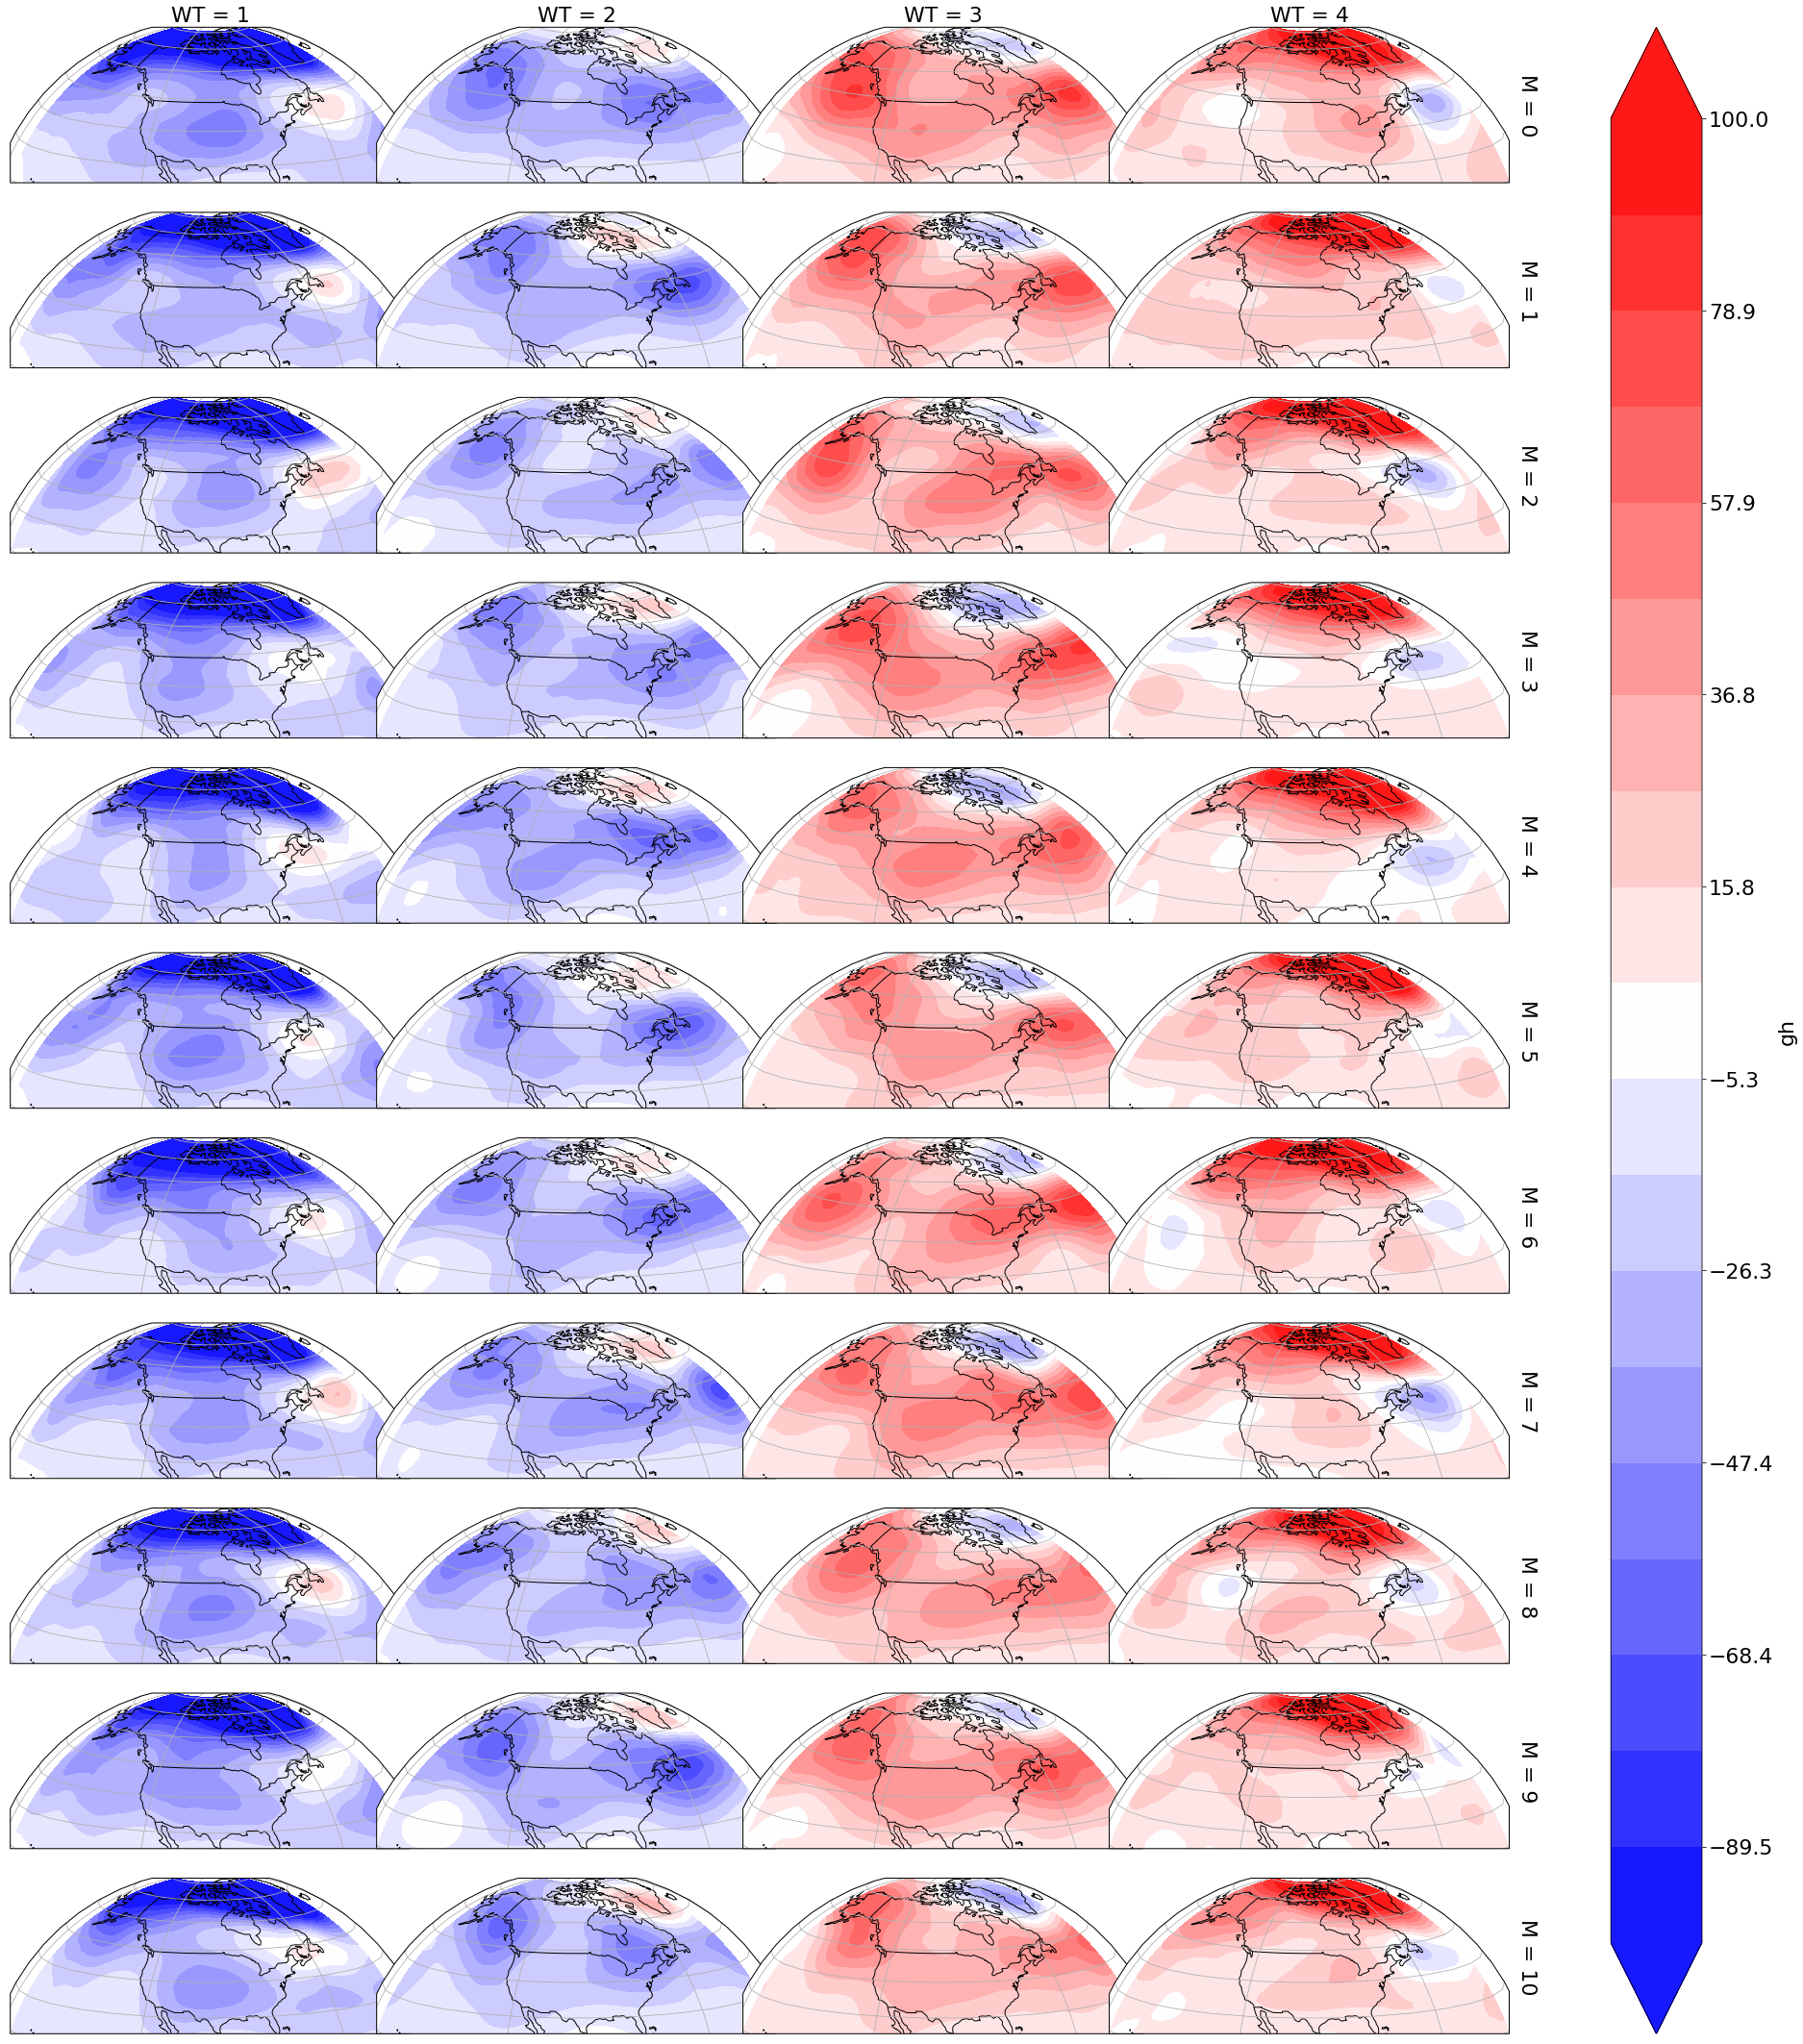

In [29]:
plt.rcParams.update({'font.size': 22})
cm=plt.cm.bwr
p = wt_anomalies.plot.contourf(
    x='X', y='Y', row='M', col='WT',
    transform=ccrs.PlateCarree(),
    #subplot_kws={'projection': ccrs.PlateCarree()},
    #subplot_kws={'projection': ccrs.LambertConformal(-80, 35)},
    subplot_kws={'projection': ccrs.Orthographic(-100, 10)},
    figsize=(27, 30),
    levels = np.linspace(-100, 100, 20),
    cmap=cm
)

xmin,xmax = wt_anomalies.X.min(), wt_anomalies.X.max()
ymin,ymax = wt_anomalies.Y.min(), wt_anomalies.Y.max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    ax.set_extent([xmin,xmax,ymin,ymax])
    #ax.set_global()
    ax.gridlines()

plt.show()